In [18]:
import math, random, copy
from typing import List, Optional

class Ability:
    def __init__(self, name: str = "NoAbility"):
        self.name = name
    def __repr__(self): return f"Ability({self.name})"

class Move:
    def __init__(self, name: str, move_type: str = "Normal", power: Optional[int] = 40,
                 accuracy: int = 100, category: str = "physical", pp: int = 10, priority: int = 0,
                 effect: Optional[callable] = None, effect_chance: Optional[float] = None):
        self.name = name
        self.move_type = move_type
        self.power = power
        self.accuracy = accuracy
        self.category = category
        self.pp = pp
        self.priority = priority
        self.effect = effect
        self.effect_chance = effect_chance

    def __repr__(self):
        return f"Move({self.name}, type={self.move_type}, power={self.power})"


_TYPE_CHART = {
    ('fire', 'grass'): 2.0,
    ('fire', 'water'): 0.5,
    ('water', 'fire'): 2.0,
    ('water', 'grass'): 0.5,
    ('grass', 'water'): 2.0,
    ('grass', 'fire'): 0.5,
}

def get_effectiveness(move_type: str, defender_types: List[str], ability: Optional[Ability] = None) -> float:
    mt = move_type.lower()
    val = 1.0
    for dt in defender_types:
        val *= _TYPE_CHART.get((mt, dt.lower()), 1.0)
    return val

class PokemonSpecies:
    def __init__(self, name: str, types: List[str], base_stats: dict,
                 ability: Ability = None, height_m: float = 1.0, weight_kg: float = 1.0,
                 pokedex_entry: str = "", front_sprite: str = "", back_sprite: str = ""):
        self.name = name
        self.types = types
        self.base_stats = base_stats
        self.ability = ability or Ability("NoAbility")
        self.height_m = height_m
        self.weight_kg = weight_kg
        self.pokedex_entry = pokedex_entry
        self.front_sprite = front_sprite
        self.back_sprite = back_sprite

    def __repr__(self):
        return f"Species({self.name})"

class PokemonInstance:
    def __init__(self, species: PokemonSpecies, level: int = 50, moves: Optional[List[Move]] = None):
        self.species = species
        self.name = species.name
        self.level = level
        self.moves = moves or []
        self.base_stats = species.base_stats.copy()
        self.stats = self.calculate_stats(level)
        self.max_hp = int(self.stats.get('hp', 50))
        self.current_hp = int(self.max_hp)
        self.stat_stages = { 'atk':0, 'def':0, 'spatk':0, 'spdef':0, 'speed':0 }
        self.status = None
        self.ability = species.ability

    def calculate_stats(self, level):
        b = self.base_stats
        return {
            'hp': int(((2 * b.get('hp',50) * level) / 100) + level + 10),
            'atk': int(((2 * b.get('atk',50) * level) / 100) + 5),
            'def': int(((2 * b.get('def',50) * level) / 100) + 5),
            'spatk': int(((2 * b.get('spatk',50) * level) / 100) + 5),
            'spdef': int(((2 * b.get('spdef',50) * level) / 100) + 5),
            'speed': int(((2 * b.get('speed',50) * level) / 100) + 5),
        }

    def fainted(self):
        return self.current_hp <= 0

    def __repr__(self):
        return f"{self.name} (HP:{self.current_hp}/{self.max_hp})"

class BattleState:
    """Simple deterministic 1v1 battle state for MCTS demo."""
    def __init__(self, p1: PokemonInstance, p2: PokemonInstance):
        self.pokemon1 = copy.deepcopy(p1)
        self.pokemon2 = copy.deepcopy(p2)
        self.turn_counter = 0

    def get_turn_order(self):

        if self.pokemon1.stats['speed'] >= self.pokemon2.stats['speed']:
            return [self.pokemon1, self.pokemon2]
        return [self.pokemon2, self.pokemon1]

    def execute_move(self, attacker: PokemonInstance, defender: PokemonInstance, move: Optional[Move]):
        if move is None:
            return

        if move.accuracy < 100:
            if random.random() > move.accuracy/100.0:

                return

        power = move.power or 40

        if move.category == 'special':
            atk_stat = attacker.stats.get('spatk', 50)
            def_stat = defender.stats.get('spdef', 50)
        else:
            atk_stat = attacker.stats.get('atk', 50)
            def_stat = defender.stats.get('def', 50)

        stab = 1.5 if move.move_type.lower() in [t.lower() for t in attacker.species.types] else 1.0
        eff = get_effectiveness(move.move_type, defender.species.types, defender.ability)
        base = ( ( (2*attacker.level/5 + 2) * power * atk_stat / max(1, def_stat) ) / 50 ) + 2
        dmg = max(1, int(base * stab * eff))
        defender.current_hp = max(0, defender.current_hp - dmg)

    def simulate_turn(self, move1: Optional[Move], move2: Optional[Move]):

        p1 = self.pokemon1; p2 = self.pokemon2
        prio1 = move1.priority if (move1 is not None) else 0
        prio2 = move2.priority if (move2 is not None) else 0
        if prio1 != prio2:
            if prio1 > prio2:
                order = [(p1, move1, p2), (p2, move2, p1)]
            else:
                order = [(p2, move2, p1), (p1, move1, p2)]
        else:

            if p1.stats['speed'] >= p2.stats['speed']:
                order = [(p1, move1, p2), (p2, move2, p1)]
            else:
                order = [(p2, move2, p1), (p1, move1, p2)]
        for (att, mv, defn) in order:
            if att.current_hp <= 0:
                continue
            self.execute_move(att, defn, mv)
        self.turn_counter += 1

    def is_terminal(self):
        return self.pokemon1.fainted() or self.pokemon2.fainted()

    def result(self):

        p1_dead = self.pokemon1.fainted()
        p2_dead = self.pokemon2.fainted()
        if p1_dead and not p2_dead:
            return -1
        if p2_dead and not p1_dead:
            return 1
        if p1_dead and p2_dead:
            return 0
        return None

    def clone(self):
        return copy.deepcopy(self)

    def __repr__(self):
        return f"Turn {self.turn_counter}: {self.pokemon1} vs {self.pokemon2}"


In [19]:
#Heuristics and wrapper for MCTS
import random, copy

class BattleStateWrapper:
    """Adapter for MCTS (agent controls pokemon1)."""
    def __init__(self, bstate: BattleState, agent_is_player1: bool = True):
        self.bstate = bstate.clone() if hasattr(bstate, 'clone') else copy.deepcopy(bstate)
        self.agent_is_player1 = agent_is_player1

    @property
    def current_player(self):
        return 1 if self.agent_is_player1 else -1

    def legal_moves(self):
        side = self.bstate.pokemon1 if self.agent_is_player1 else self.bstate.pokemon2
        return list(side.moves)

    def make_move(self, move):
        s = self.bstate.clone() if hasattr(self.bstate, 'clone') else copy.deepcopy(self.bstate)
        # opponent policy: random(for now)
        if self.agent_is_player1:
            opp = s.pokemon2
            opp_move = random.choice(opp.moves) if opp.moves else None
            s.simulate_turn(move, opp_move)
        else:
            opp = s.pokemon1
            opp_move = random.choice(opp.moves) if opp.moves else None
            s.simulate_turn(opp_move, move)
        return BattleStateWrapper(s, agent_is_player1=self.agent_is_player1)

    def is_terminal(self):
        return self.bstate.is_terminal()

    def result(self):
        r = self.bstate.result()
        return r

def heuristic_eval(wrapper: BattleStateWrapper):
    # Quick heuristic: HP diff + best-move potential + mobility (for now)
    s = wrapper.bstate
    agent = s.pokemon1
    opp = s.pokemon2
    hp_diff = (agent.current_hp - opp.current_hp) / max(1, agent.max_hp)
    def est_damage(move, atk, tgt):
        if move is None: return 0.0
        power = getattr(move, 'power', 40) or 40
        try:
            eff = get_effectiveness(move.move_type, tgt.species.types, tgt.species.ability)
        except Exception:
            eff = 1.0
        stab = 1.5 if move.move_type.lower() in [t.lower() for t in atk.species.types] else 1.0
        return power * stab * eff * (atk.stats.get('atk',50) / max(1, tgt.stats.get('def',50)))
    max_agent = max((est_damage(m, agent, opp) for m in agent.moves), default=0.0)
    max_opp = max((est_damage(m, opp, agent) for m in opp.moves), default=0.0)
    pot_diff = (max_agent - max_opp) / 100.0
    mobility = (len(agent.moves) - len(opp.moves)) / 4.0
    score = 2.0 * hp_diff + pot_diff + 0.5 * mobility
    return score


In [20]:
# MCTS implementation (UCT) with tree collection utilities
import math, random, time

class MCTSNode:
    def __init__(self, state_wrapper, parent=None, move=None):
        self.state = state_wrapper
        self.parent = parent
        self.move = move
        self.children = {}
        self.untried_moves = None
        self.visits = 0
        self.value = 0.0

    def is_fully_expanded(self):
        if self.untried_moves is None:
            self.untried_moves = self.state.legal_moves()
        return len(self.untried_moves) == 0

    def expand(self):
        if self.untried_moves is None:
            self.untried_moves = self.state.legal_moves()
        if not self.untried_moves:
            return None
        m = self.untried_moves.pop(random.randrange(len(self.untried_moves)))
        child_state = self.state.make_move(m)
        child = MCTSNode(child_state, parent=self, move=m)
        self.children[m] = child
        return child

    def best_child(self, c_param=1.4):
        best = None; best_score = -1e9
        for m,ch in self.children.items():
            if ch.visits == 0:
                score = float('inf')
            else:
                exploit = ch.value / ch.visits
                explore = c_param * math.sqrt(2 * math.log(self.visits) / ch.visits)
                score = exploit + explore
            if score > best_score:
                best_score = score; best = ch
        return best

class MCTS:
    def __init__(self, rollout_policy=None, c=1.4, max_iters=1000, max_time=None):
        self.rollout_policy = rollout_policy
        self.c = c
        self.max_iters = max_iters
        self.max_time = max_time
        self.root = None

    def tree_policy(self, node):
        while not node.state.is_terminal():
            if not node.is_fully_expanded():
                return node.expand()
            else:
                node = node.best_child(self.c)
                if node is None: break
        return node

    def default_policy(self, state_wrapper):
        s = state_wrapper
        if s.is_terminal():
            r = s.result(); return 0.0 if r is None else float(r)
        while not s.is_terminal():
            moves = s.legal_moves()
            if not moves: break
            if self.rollout_policy and random.random() < 0.9:
                mv = self.rollout_policy(s)
                if mv not in moves: mv = random.choice(moves)
            else:
                mv = random.choice(moves)
            s = s.make_move(mv)
        r = s.result()
        return 0.0 if r is None else float(r)

    def backup(self, node, reward, start_player):
        n = node
        while n is not None:
            n.visits += 1
            cp = getattr(n.state, 'current_player', None)
            if cp is None or cp == start_player:
                n.value += reward
            else:
                n.value -= reward
            n = n.parent

    def search(self, root_state):
        self.root = MCTSNode(root_state)
        iters = 0; start = time.time()
        while True:
            if self.max_time is not None and time.time() - start > self.max_time:
                break
            if self.max_iters is not None and iters >= self.max_iters:
                break
            iters += 1
            node = self.tree_policy(self.root)
            reward = self.default_policy(node.state)
            start_player = node.state.current_player
            self.backup(node, reward, start_player)

        best_move, best_vis = None, -1
        for m,ch in self.root.children.items():
            if ch.visits > best_vis:
                best_vis = ch.visits; best_move = m
        return best_move

def collect_tree_data(root, max_nodes=500):
    nodes = []; edges = []
    q = [(root, None)]; idx = 0; id_map = {id(root): idx}; nodes.append({'id':idx,'label':'root','vis':root.visits,'val':root.value}); idx+=1
    while q and len(id_map) < max_nodes:
        node, parent = q.pop(0)
        nid = id_map[id(node)]
        for m,ch in node.children.items():
            if id(ch) not in id_map:
                id_map[id(ch)] = idx
                nodes.append({'id': idx, 'label': getattr(m,'name',str(m))[:20], 'vis': ch.visits, 'val': ch.value})
                idx += 1
                q.append((ch, nid))
            edges.append({'source': nid, 'target': id_map[id(ch)], 'move': getattr(m,'name',str(m))})
    return {'nodes': nodes, 'edges': edges}


In [21]:
import random, pprint

random.seed(42)


# --- Only Demo (for now) ---
# --- Setup demo moves ---
m_tackle = Move('Tackle', 'Normal', power=40)
m_quick = Move('QuickAttack', 'Normal', power=40, priority=1)
m_ember = Move('Ember', 'Fire', power=40)
m_water = Move('WaterGun', 'Water', power=40)
m_thunder = Move('ThunderShock', 'Electric', power=40)
m_vine = Move('VineWhip', 'Grass', power=45)
m_bite = Move('Bite', 'Dark', power=60)
m_ice = Move('IceBeam', 'Ice', power=65)
m_rock = Move('RockThrow', 'Rock', power=50)

# --- Setup demo species ---
s_normal = PokemonSpecies('MonA', ['Normal'], {'hp':60,'atk':50,'def':45,'spatk':40,'spdef':40,'speed':45}, Ability('NoAbility'))
s_fire   = PokemonSpecies('MonB', ['Fire'], {'hp':55,'atk':52,'def':43,'spatk':55,'spdef':40,'speed':60}, Ability('Blaze'))
s_water  = PokemonSpecies('MonC', ['Water'], {'hp':58,'atk':48,'def':50,'spatk':50,'spdef':48,'speed':52}, Ability('Torrent'))
s_grass  = PokemonSpecies('MonD', ['Grass'], {'hp':62,'atk':49,'def':50,'spatk':55,'spdef':50,'speed':48}, Ability('Overgrow'))
s_electric = PokemonSpecies('MonE', ['Electric'], {'hp':50,'atk':55,'def':40,'spatk':65,'spdef':40,'speed':70}, Ability('Static'))
s_rock   = PokemonSpecies('MonF', ['Rock'], {'hp':65,'atk':60,'def':55,'spatk':40,'spdef':45,'speed':35}, Ability('Sturdy'))

# --- Create player & opponent Pokémon with diversity ---
p1_team = [
    PokemonInstance(s_fire, level=50, moves=[m_ember, m_quick, m_bite, m_tackle]),
    PokemonInstance(s_grass, level=50, moves=[m_vine, m_tackle, m_quick, m_bite]),
    PokemonInstance(s_electric, level=50, moves=[m_thunder, m_quick, m_tackle, m_bite])
]

p2_team = [
    PokemonInstance(s_water, level=50, moves=[m_water, m_tackle, m_ice, m_bite]),
    PokemonInstance(s_rock, level=50, moves=[m_rock, m_tackle, m_bite, m_ice]),
    PokemonInstance(s_normal, level=50, moves=[m_tackle, m_quick, m_bite, m_vine])
]

# --- Initialize battle ---
bstate = BattleState(p1_team[0], p2_team[0])
wrapper = BattleStateWrapper(bstate, agent_is_player1=True)

mcts = MCTS(rollout_policy=heuristic_eval, c=1.4, max_iters=800, max_time=None)

trees, hp_hist, moves_log = [], [], []
turn = 0

# --- Main game loop ---
while not wrapper.is_terminal() and turn < 50:
    turn += 1
    print(f"\n=== TURN {turn} ===")
    print(wrapper.bstate)

    # MCTS search for best move
    best = mcts.search(wrapper)
    if best is None:
        legal = wrapper.legal_moves()
        best = random.choice(legal) if legal else None
    print("Agent move:", getattr(best, 'name', best))

    # Random opponent move
    opp_move = random.choice(wrapper.bstate.pokemon2.moves)
    print("Opponent move:", getattr(opp_move, 'name', opp_move))

    # Apply to battle state
    wrapper.bstate.simulate_turn(best, opp_move)

    # Record stats
    hp_hist.append((wrapper.bstate.pokemon1.current_hp, wrapper.bstate.pokemon2.current_hp))
    moves_log.append((getattr(best,'name',str(best)), getattr(opp_move,'name',str(opp_move))))

    # Replace fainted Pokémon with next available
    if wrapper.bstate.pokemon1.current_hp <= 0:
        next_alive = next((p for p in p1_team if p.current_hp > 0), None)
        if next_alive:
            wrapper.bstate.pokemon1 = next_alive
    if wrapper.bstate.pokemon2.current_hp <= 0:
        next_alive = next((p for p in p2_team if p.current_hp > 0), None)
        if next_alive:
            wrapper.bstate.pokemon2 = next_alive

    # Save tree snapshot
    trees.append(collect_tree_data(mcts.root, max_nodes=300))
    wrapper = BattleStateWrapper(wrapper.bstate, agent_is_player1=True)

print("\nGame over! Result (1=p1 win, -1=p2 win, 0=draw):", wrapper.result())
pprint.pprint(moves_log)



=== TURN 1 ===
Turn 0: MonB (HP:115/115) vs MonC (HP:118/118)
Agent move: Bite
Opponent move: IceBeam

=== TURN 2 ===
Turn 1: MonB (HP:82/115) vs MonC (HP:89/118)
Agent move: Tackle
Opponent move: IceBeam

=== TURN 3 ===
Turn 2: MonB (HP:49/115) vs MonC (HP:69/118)
Agent move: Bite
Opponent move: WaterGun

=== TURN 4 ===
Turn 3: MonB (HP:115/115) vs MonC (HP:40/118)
Agent move: QuickAttack
Opponent move: Bite

=== TURN 5 ===
Turn 4: MonB (HP:84/115) vs MonC (HP:20/118)
Agent move: Bite
Opponent move: Tackle

=== TURN 6 ===
Turn 5: MonB (HP:84/115) vs MonC (HP:118/118)
Agent move: Tackle
Opponent move: IceBeam

=== TURN 7 ===
Turn 6: MonB (HP:51/115) vs MonC (HP:98/118)
Agent move: Tackle
Opponent move: WaterGun

=== TURN 8 ===
Turn 7: MonB (HP:115/115) vs MonC (HP:78/118)
Agent move: Bite
Opponent move: IceBeam

=== TURN 9 ===
Turn 8: MonB (HP:82/115) vs MonC (HP:49/118)
Agent move: Bite
Opponent move: WaterGun

=== TURN 10 ===
Turn 9: MonB (HP:18/115) vs MonC (HP:20/118)
Agent move: 

In [23]:

import math
import numpy as np
import pandas as pd
import networkx as nx


try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    HAS_PLOTLY = True
except Exception as e:
    print("Plotly not available; falling back to matplotlib. Error:", e)
    HAS_PLOTLY = False
    import matplotlib.pyplot as plt

if len(trees) == 0:
    print("No trees collected. Run the play loop (Cell 4) to gather trees.")
else:
    last = trees[-1]
    nodes = last['nodes']
    edges = last['edges']

    # Build NetworkX graph (directed) and attach attributes
    G = nx.DiGraph()
    for n in nodes:
        G.add_node(n['id'], label=n['label'], visits=n['vis'], value=n['val'])
    for e in edges:
        G.add_edge(e['source'], e['target'], move=e.get('move',''))


    node_count = G.number_of_nodes()
    layout_dim = 3

    try:
        pos = nx.spring_layout(G, dim=3, seed=42)  # returns dict node -> (x,y,z)
    except Exception:

        pos2 = nx.spring_layout(G, seed=42)
        pos = {n: (xy[0], xy[1], np.random.normal(scale=0.01)) for n,xy in pos2.items()}

    # build arrays for plot
    node_x = []; node_y = []; node_z = []
    node_text = []; node_size = []; node_color = []
    visits = np.array([G.nodes[n].get('visits',0) for n in G.nodes()])
    vals = np.array([G.nodes[n].get('value',0.0) for n in G.nodes()])
    minv, maxv = visits.min() if len(visits)>0 else 0, visits.max() if len(visits)>0 else 1

    for n in G.nodes():
        x,y,z = pos[n]
        node_x.append(x); node_y.append(y); node_z.append(z)
        lab = G.nodes[n].get('label','')
        vis = G.nodes[n].get('visits',0)
        val = G.nodes[n].get('value',0.0)
        node_text.append(f"#{n} {lab}<br>visits: {vis}<br>value: {val:.2f}")

        size = 8 + (math.sqrt(vis) * 6 if vis>0 else 0)
        node_size.append(size)
        node_color.append(val)

    # edges as segments for 3D lines
    edge_x = []; edge_y = []; edge_z = []; edge_text = []
    for u,v,d in G.edges(data=True):
        x0,y0,z0 = pos[u]
        x1,y1,z1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
        edge_z += [z0, z1, None]
        edge_text.append(d.get('move',''))

    if HAS_PLOTLY:
        # 3D tree figure
        node_trace = go.Scatter3d(
            x=node_x, y=node_y, z=node_z,
            mode='markers',
            marker=dict(size=node_size, color=node_color, colorscale='RdYlGn', colorbar=dict(title='value')),
            text=node_text,
            hoverinfo='text'
        )

        edge_trace = go.Scatter3d(
            x=edge_x, y=edge_y, z=edge_z,
            mode='lines',
            line=dict(width=2, color='rgba(100,100,100,0.5)'),
            hoverinfo='none'
        )

        # Also create a 2D projection with labels
        proj_x = [x for x in node_x]
        proj_y = [y for y in node_y]
        labels = [G.nodes[n].get('label','') for n in G.nodes()]

        # Build HP timeline traces
        hp_agent = [h[0] for h in hp_hist] if len(hp_hist)>0 else []
        hp_opp = [h[1] for h in hp_hist] if len(hp_hist)>0 else []
        turns = list(range(1, len(hp_agent)+1))

        fig = make_subplots(rows=2, cols=2,
                            specs=[[{'type':'scene'}, {'type':'xy'}],
                                   [{'type':'xy'}, {'type':'table'}]],
                            subplot_titles=("MCTS Search Tree (3D)", "HP Timeline", "Top Child Visits", "Best Nodes Table"))

        fig.add_trace(edge_trace, row=1, col=1)
        fig.add_trace(node_trace, row=1, col=1)

        # HP timeline
        if len(hp_agent)>0:
            fig.add_trace(go.Scatter(x=turns, y=hp_agent, mode='lines+markers', name='Agent HP'), row=1, col=2)
            fig.add_trace(go.Scatter(x=turns, y=hp_opp, mode='lines+markers', name='Opponent HP'), row=1, col=2)
            fig.update_xaxes(title_text='Turn', row=1, col=2)
            fig.update_yaxes(title_text='HP', row=1, col=2)

        # Top child visits bar plot (root children)
        root_children = [(G.nodes[ch]['label'], G.nodes[ch]['visits'], G.nodes[ch]['value']) for ch in G.nodes()]

        root_id = None
        for n in G.nodes():
            if str(G.nodes[n].get('label','')).lower().startswith('root') or G.nodes[n].get('label','') == 'root':
                root_id = n
                break
        if root_id is None:

            root_id = max(G.nodes(), key=lambda x: G.nodes[x].get('visits',0))
        # children of that root
        child_info = []
        for _,v in G[root_id].items():
            cid = v
        # Actually get neighbors
        child_info = []
        for v in G.successors(root_id):
            child_info.append((G.nodes[v].get('label',''), G.nodes[v].get('visits',0), G.nodes[v].get('value',0.0)))
        if not child_info:

            child_info = sorted([(G.nodes[n].get('label',''), G.nodes[n].get('visits',0), G.nodes[n].get('value',0.0)) for n in G.nodes()],
                                key=lambda x: x[1], reverse=True)[:10]

        labels_bar = [c[0] for c in child_info]
        visits_bar = [c[1] for c in child_info]
        fig.add_trace(go.Bar(x=labels_bar, y=visits_bar, name='Visits'), row=2, col=1)
        fig.update_xaxes(tickangle= -45, row=2, col=1)
        fig.update_yaxes(title_text='Visits', row=2, col=1)


        top_nodes = sorted(nodes, key=lambda x: x['vis'], reverse=True)[:20]
        tbl = go.Table(header=dict(values=["label","visits","value"]),
                       cells=dict(values=[[t['label'] for t in top_nodes],[t['vis'] for t in top_nodes],[t['val'] for t in top_nodes]]))
        fig.add_trace(tbl, row=2, col=2)

        fig.update_layout(height=900, showlegend=False, title_text="Interactive MCTS Dashboard")
        fig.show()

    else:

        import matplotlib.pyplot as plt

        plt.figure(figsize=(10,8))
        pos2 = {n: (pos[n][0], pos[n][1]) for n in pos}
        sizes = [50 + 20 * G.nodes[n].get('visits',0) for n in G.nodes()]
        colors = [G.nodes[n].get('value',0) for n in G.nodes()]
        nx.draw(G, pos2, with_labels=False, node_size=sizes, node_color=colors, cmap=plt.cm.RdYlGn)
        labels = {n: f"{G.nodes[n]['label']}\nvis:{G.nodes[n]['visits']}\nval:{G.nodes[n]['value']:.1f}" for n in G.nodes()}
        nx.draw_networkx_labels(G, pos2, labels, font_size=8)
        plt.title("MCTS search tree (static)")
        plt.show()

        # HP timeline
        if len(hp_hist) > 0:
            arr = np.array(hp_hist)
            plt.figure(figsize=(8,4))
            plt.plot(np.arange(1, arr.shape[0]+1), arr[:,0], marker='o', label='Agent HP')
            plt.plot(np.arange(1, arr.shape[0]+1), arr[:,1], marker='o', label='Opp HP')
            plt.xlabel('Turn'); plt.ylabel('HP'); plt.legend(); plt.grid(True)
            plt.show()

# Also print a concise visits table in notebook
if len(trees) > 0:
    last_nodes = last['nodes']
    top = sorted(last_nodes, key=lambda x: x['vis'], reverse=True)[:20]
    df_top = pd.DataFrame(top)
    display(df_top)
else:
    print("No tree data to show top nodes.")


,id,label,vis,val
0,0,root,800,720.0
1,3,Bite,636,616.0
2,15,Ember,190,190.0
3,16,Bite,190,190.0
4,14,QuickAttack,156,150.0
5,1,Ember,150,116.0
6,13,Tackle,99,85.0
7,6,Bite,84,78.0
8,7,QuickAttack,56,46.0
9,42,Tackle,51,51.0


Starting state-space exploration with MAX_DEPTH= 5 MAX_NODES= 200000
Exploration finished in 0.11s — visited unique states: 47, edges seen: 148

--- Metrics ---
Unique states: 47
Total edges observed: 148
Avg branching factor (observed nodes with moves): 4.0
Max branching factor: 4
Depth distribution (nodes at each depth):
{0: 1, 1: 4, 2: 12, 3: 10, 4: 10, 5: 10}


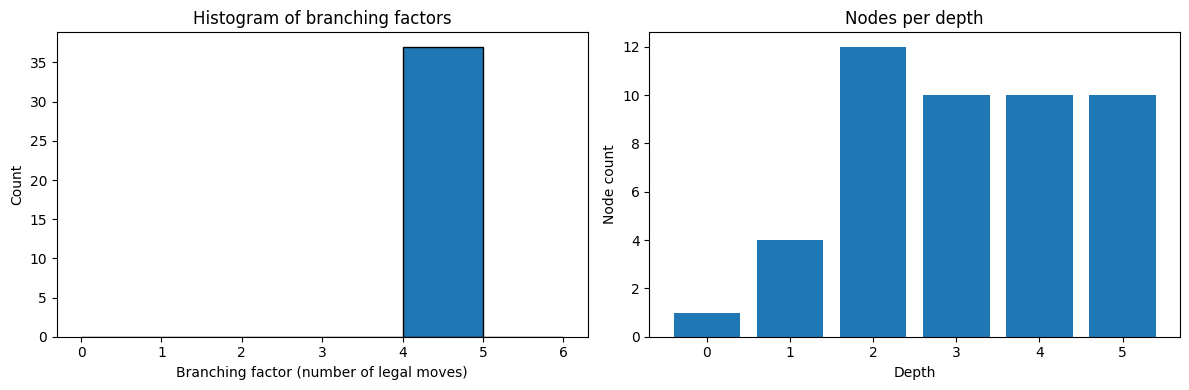

Building NetworkX graph (this may be slow for large graphs)...
Graph nodes: 47 edges: 50


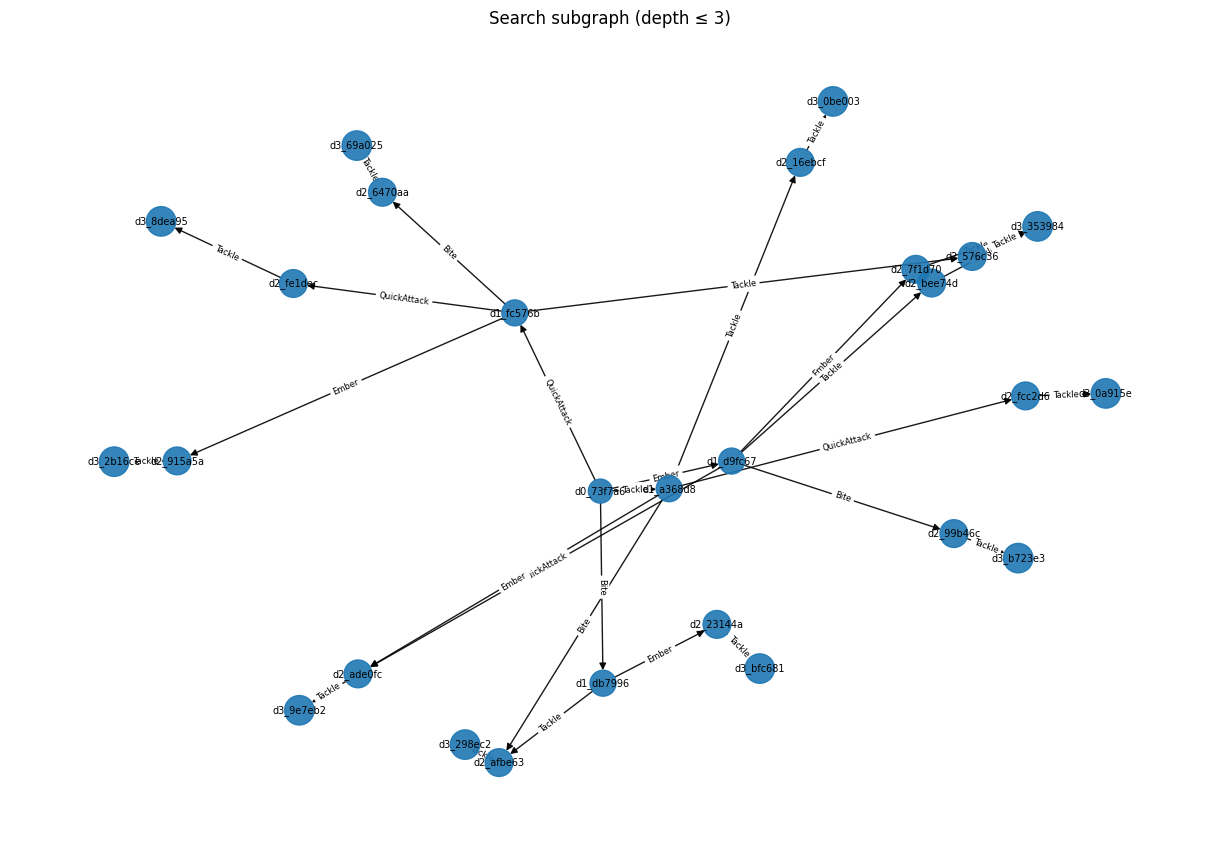


Estimated full tree size under uniform branching (avg=4.00) up to depth 5: 1,365


In [25]:
# Cell 6 — Exhaustive search-tree space analysis (BFS up to depth D, deduplicating states)
import collections, hashlib, json, time
import math
import matplotlib.pyplot as plt
import networkx as nx
from pprint import pprint

# Controls (tweak these)
MAX_DEPTH = 5        # depth to explore (each depth = one agent decision -> opponent decision pair in wrapper model)
MAX_NODES = 200000   # safety cap on total visited nodes to avoid explosion
BUILD_GRAPH_MAX = 5000  # if unique states <= this, build networkx graph for visualization

# Helper: robust state hashing that tries to capture underlying game state of wrappers.
def state_key(wrapper):
    """
    Produce a compact, hashable key for a wrapper state.
    Works with:
      - BattleStateWrapper (wrapper.bstate)
      - MultiBattleWrapper (wrapper.eb)
      - MultiBattleWrapper-like wrappers with .eb or .bstate or .state
      - BattleState (p1,p2)
      - EnhancedBattleState (team1/team2, active indices, weather, items)
    """
    # unwrap common wrapper shapes
    s = None
    if hasattr(wrapper, 'eb'):
        s = wrapper.eb
    elif hasattr(wrapper, 'bstate'):
        s = wrapper.bstate
    elif hasattr(wrapper, 'state'):
        s = wrapper.state
    else:
        # assume wrapper is a raw battle-like object
        s = wrapper

    # Build a serializable summary dict
    info = {}
    # Enhanced team-based
    if hasattr(s, 'team1') and hasattr(s, 'team2'):
        info['weather'] = getattr(s, 'weather', None)
        info['active1'] = getattr(s, 'active1', 0)
        info['active2'] = getattr(s, 'active2', 0)
        def team_summary(team):
            lst = []
            for p in team:
                lst.append((
                    getattr(p, 'name', None),
                    int(getattr(p, 'current_hp', getattr(p, 'current_hp', 0))),
                    int(getattr(p, 'max_hp', getattr(p, 'max_hp', 0))),
                    tuple(sorted(getattr(p, 'status', {}) if isinstance(getattr(p,'status',None), dict) else [getattr(p,'status',None)])),
                    tuple((getattr(m, '_pp_remaining', getattr(m,'pp', None)) for m in getattr(p, 'moves', [])))
                ))
            return lst
        info['team1'] = team_summary(s.team1)
        info['team2'] = team_summary(s.team2)
        # items if present
        info['items'] = getattr(s, 'items', None)
    # simple 1v1 BattleState
    elif hasattr(s, 'pokemon1') and hasattr(s, 'pokemon2'):
        p1 = s.pokemon1; p2 = s.pokemon2
        info['p1'] = (getattr(p1,'name',None), int(getattr(p1,'current_hp',0)), int(getattr(p1,'max_hp',0)),
                      tuple(sorted(getattr(p1,'status',{}) if isinstance(getattr(p1,'status',None), dict) else [getattr(p1,'status',None)])),
                      tuple((getattr(m,'_pp_remaining', getattr(m,'pp', None)) for m in getattr(p1,'moves',[]))))
        info['p2'] = (getattr(p2,'name',None), int(getattr(p2,'current_hp',0)), int(getattr(p2,'max_hp',0)),
                      tuple(sorted(getattr(p2,'status',{}) if isinstance(getattr(p2,'status',None), dict) else [getattr(p2,'status',None)])),
                      tuple((getattr(m,'_pp_remaining', getattr(m,'pp', None)) for m in getattr(p2,'moves',[]))))
        info['turn'] = getattr(s, 'turn_counter', getattr(s, 'turn', None))
    else:
        # best-effort fallback: use repr
        info['repr'] = repr(s)

    # deterministic serialization
    j = json.dumps(info, sort_keys=True, default=lambda x: str(x))
    # hash to keep keys short
    return hashlib.sha1(j.encode('utf-8')).hexdigest()

# BFS exploration
def explore_state_space(root_wrapper, max_depth=4, max_nodes=20000):
    start = time.time()
    visited = {}  # state_key -> (depth, parent_key, move_from_parent_repr)
    q = collections.deque()
    root_key = state_key(root_wrapper)
    visited[root_key] = (0, None, None)
    q.append((root_wrapper, root_key, 0))
    node_count = 0
    branching = []    # observed branching factors (number of legal moves at node)
    depth_counts = collections.Counter()
    edges = []        # (parent_key, child_key, move_repr)

    while q:
        state_wr, st_key, depth = q.popleft()
        if node_count >= max_nodes:
            print("Reached MAX_NODES safety cap:", max_nodes); break
        if depth >= max_depth:
            depth_counts[depth] += 1
            continue

        try:
            moves = state_wr.legal_moves()
        except Exception as e:
            # if wrapper doesn't provide legal_moves, skip
            moves = []
        b = len(moves)
        branching.append(b)
        depth_counts[depth] += 1

        for mv in moves:
            # try to skip impossible PP=0 moves quickly
            try:
                if getattr(mv, '_pp_remaining', getattr(mv, 'pp', 1)) == 0:
                    continue
            except Exception:
                pass
            try:
                child = state_wr.make_move(mv)
            except Exception as e:

                continue
            child_key = state_key(child)
            edges.append((st_key, child_key, getattr(mv, 'name', str(mv))))
            if child_key not in visited:
                visited[child_key] = (depth+1, st_key, getattr(mv,'name',str(mv)))
                q.append((child, child_key, depth+1))
            node_count += 1
            if node_count >= max_nodes:
                break
        if node_count >= max_nodes:
            break

    elapsed = time.time() - start
    print(f"Exploration finished in {elapsed:.2f}s — visited unique states: {len(visited)}, edges seen: {len(edges)}")
    return {
        'visited': visited,
        'edges': edges,
        'branching': branching,
        'depth_counts': depth_counts,
        'elapsed': elapsed
    }

# Run exploration
print("Starting state-space exploration with MAX_DEPTH=", MAX_DEPTH, "MAX_NODES=", MAX_NODES)
res = explore_state_space(wrapper, max_depth=MAX_DEPTH, max_nodes=MAX_NODES)

# Metrics
unique_states = len(res['visited'])
total_edges = len(res['edges'])
branching = res['branching']
depth_counts = res['depth_counts']

print("\n--- Metrics ---")
print("Unique states:", unique_states)
print("Total edges observed:", total_edges)
if branching:
    print("Avg branching factor (observed nodes with moves):", sum(branching)/len(branching))
    print("Max branching factor:", max(branching))
else:
    print("No branching data collected (no moves?)")
print("Depth distribution (nodes at each depth):")
pprint(dict(depth_counts))

# Visualizations: branching histogram and depth bar plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
if branching:
    plt.hist(branching, bins=range(0, max(max(branching, default=1),5)+2), edgecolor='black')
    plt.title('Histogram of branching factors')
    plt.xlabel('Branching factor (number of legal moves)')
    plt.ylabel('Count')
else:
    plt.text(0.5,0.5,"No branching data", ha='center')

plt.subplot(1,2,2)
depths = sorted(depth_counts.items())
if depths:
    ds, cs = zip(*depths)
    plt.bar([str(d) for d in ds], cs)
    plt.title('Nodes per depth')
    plt.xlabel('Depth')
    plt.ylabel('Node count')
else:
    plt.text(0.5,0.5,"No depth data", ha='center')
plt.tight_layout()
plt.show()


if unique_states <= BUILD_GRAPH_MAX:
    print("Building NetworkX graph (this may be slow for large graphs)...")
    G = nx.DiGraph()
    for k, (depth, parent, mvname) in res['visited'].items():

        label = f"d{depth}_{k[:6]}"
        G.add_node(k, label=label, depth=depth)
    for parent, child, mvname in res['edges']:
        if parent in G.nodes and child in G.nodes:
            G.add_edge(parent, child, move=mvname)
    print("Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

    # Draw only the subgraph of nodes up to depth 3 (to keep visualization readable)
    sel_nodes = [n for n,d in G.nodes(data=True) if d.get('depth',999) <= min(3, MAX_DEPTH)]
    SG = G.subgraph(sel_nodes).copy()
    plt.figure(figsize=(12,8))
    pos = nx.spring_layout(SG, seed=42)
    node_labels = {n: G.nodes[n]['label'] for n in SG.nodes()}
    node_sizes = [300 + 50 * G.nodes[n].get('depth',0) for n in SG.nodes()]
    nx.draw(SG, pos, with_labels=False, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_labels(SG, pos, labels=node_labels, font_size=7)
    edge_labels = {(u,v): d.get('move','') for u,v,d in SG.edges(data=True)}
    nx.draw_networkx_edge_labels(SG, pos, edge_labels=edge_labels, font_size=6)
    plt.title(f"Search subgraph (depth ≤ {min(3, MAX_DEPTH)})")
    plt.show()
else:
    print(f"Graph too large to build (unique_states={unique_states} > BUILD_GRAPH_MAX={BUILD_GRAPH_MAX}). Skipping graph construction.")


if branching:
    avg_b = sum(branching)/len(branching)
    est_full = sum(avg_b**d for d in range(0, MAX_DEPTH+1))
    print(f"\nEstimated full tree size under uniform branching (avg={avg_b:.2f}) up to depth {MAX_DEPTH}: {int(est_full):,}")


search_space_analysis = res
